# Orca memory equations

In [1]:
from fast import *
from fast.config import fast_path
from matplotlib import pyplot
from sympy import sin,cos,exp,sqrt,pi,zeros,I, Integral, oo, integrate, Equality, Mul, diff, DiracDelta, simplify
from sympy import re, im
from numpy import array
%matplotlib inline
init_printing()
print_ascii=True; print_ascii=False

In [2]:
path="/home/oscar/oxford/inhomogeneous_broadening/complete_model/" 
name='orca'

We will be deriving the optical Bloch equations for a three level system in a ladder configuration as that in the figure.

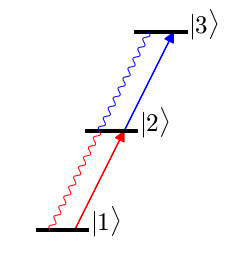

In [3]:
fig=pyplot.figure(); ax=fig.add_subplot(111,aspect="equal")

p1=[0.5,1]; p2=[1.5,3]; p3=[2.5,5]
draw_state(ax,p1,text=r"$|1\rangle$",l=1.0,alignment='right',label_displacement=0.05,fontsize=25,linewidth=4.0)
draw_state(ax,p2,text=r"$|2\rangle$",l=1.0,alignment='right',label_displacement=0.05,fontsize=25,linewidth=4.0)
draw_state(ax,p3,text=r"$|3\rangle$",l=1.0,alignment='right',label_displacement=0.05,fontsize=25,linewidth=4.0)

excitation(ax,[p1[0]+0.25,p1[1]],[p2[0]+0.25,p2[1]], fc="r", ec="r",width=0.01, head_width=0.2, head_length=0.2)
excitation(ax,[p2[0]+0.25,p2[1]],[p3[0]+0.25,p3[1]], fc="b", ec="b",width=0.01, head_width=0.2, head_length=0.2)

decay(     ax,[p1[0]-0.25,p1[1]],[p2[0]-0.25,p2[1]], 0.05,10.0,color="r",linewidth=1.0)
decay(     ax,[p2[0]-0.25,p2[1]],[p3[0]-0.25,p3[1]], 0.05,10.0,color="b",linewidth=1.0)

pyplot.axis('off')
pyplot.savefig(path+name+'_diagram.png',bbox_inches="tight")

We define the number of states and of radiation fields.

In [4]:
Ne=3
Nl=2

We define a few important symbols.

In [5]:
c,hbar,e,mu0, epsilon0=symbols("c hbar e mu0 varepsilon0",positive=True)
# fprint([c,hbar,e,mu0, epsilon0],print_ascii=print_ascii)

In [6]:
t, X, Y, Z, R, Phi=symbols("t X Y Z R Phi",real=True)
RR = Matrix([R*cos(Phi), R*sin(Phi), Z])
# RR=Matrix([X,Y,Z])
# fprint([t,RR],print_ascii=print_ascii)

We define the variables related to the laser field.

In [7]:
E0,omega_laser=define_laser_variables(Nl, variables=[t, Z])
# fprint(E0,print_ascii=print_ascii)

In [8]:
# fprint(omega_laser,print_ascii=print_ascii)

We write two electric fields propagating trough the $\hat{x}$ direction polarized in the $\hat{z}$ direction. First the wave vectors:

In [9]:
phi1=0 ; theta1=0; alpha1=pi/2; beta1=pi/8
phi2=0; theta2=pi; alpha2=pi/2; beta2=pi/8

k1=Matrix([cos(phi1)*sin(theta1),sin(phi1)*sin(theta1),cos(theta1)])
k2=Matrix([cos(phi2)*sin(theta2),sin(phi2)*sin(theta2),cos(theta2)])

k=[k1,k2]

# fprint(k,print_ascii=print_ascii)

The polarization vectors.

In [10]:
ep1=polarization_vector(phi1,theta1,alpha1,beta1, 1)
ep2=polarization_vector(phi2,theta2,alpha2,beta2, 1)

em1=ep1.conjugate()
em2=ep2.conjugate()

ep=[ep1,ep2]
em=[em1,em2]

# fprint([ep,em],print_ascii=print_ascii)

The electric field (evaluated in $\vec{R}=0$).

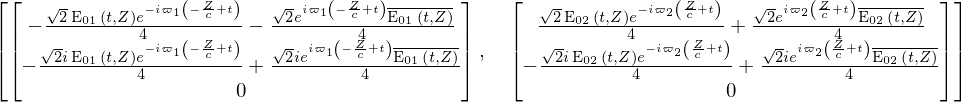

In [11]:
zero_vect=Matrix([0,0,0])
E_cartesian = [(+E0[l]            *ep[l]*exp(-I*omega_laser[l]*(t-k[l].dot(RR)/c)) 
                +E0[l].conjugate()*em[l]*exp(+I*omega_laser[l]*(t-k[l].dot(RR)/c)))/2 
                    for l in range(Nl)]

E_cartesian

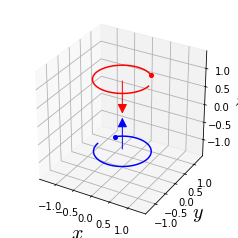

In [12]:
l1 = PlaneWave(phi1,theta1,alpha1,beta1,color="blue")
l2 = PlaneWave(phi2,theta2,alpha2,beta2,color="red")

laseres = [l1, l2]
Nl = len(laseres)

fig = pyplot.figure(); ax = fig.gca(projection='3d')
draw_lasers_3d(ax,laseres,path+name+'_lasers.png')

We write the electric fields in the helicity basis (see notebook "Vectors in the helicity basis and the electric field").

In [13]:
E = [cartesian_to_helicity(E_cartesian[l]).expand() for l in range(Nl)]
# fprint(E,print_ascii=print_ascii)

We define the position operator.

In [14]:
r = define_r_components(Ne,helicity=True,explicitly_hermitian=True)
#Ladder means that r_{p;31}=0
r = [ri.subs({r[0][2,0]:0,r[1][2,0]:0,r[2][2,0]:0}) for ri in r]
# fprint(r,print_ascii=print_ascii)

The frequencies of the energy levels, the resonant frequencies, and the decay frequencies.

In [15]:
omega_level, omega, gamma = define_frequencies(Ne,explicitly_antisymmetric=True)
#Ladder means gamma31=0
gamma = gamma.subs({gamma[2,0]:0})
# fprint(omega_level,print_ascii=print_ascii)

In [16]:
# fprint(omega, print_ascii=print_ascii)

In [17]:
# fprint(gamma, print_ascii=print_ascii)

The atomic hamiltonian is

In [18]:
H0 = Matrix([[hbar*omega_level[i]*KroneckerDelta(i,j) for j in range(Ne)] for i in range(Ne)])
# fprint(H0, print_ascii=print_ascii)

The interaction hamiltonian is

In [19]:
zero_matrix = zeros(Ne,Ne)
H1 = sum([e*helicity_dot_product(E[l],r) for l in range(Nl)],zero_matrix)
# fprint(H1,print_ascii=print_ascii)

and the complete hamiltonian is

In [20]:
H = H0 + H1

# Rotating wave approximation
Notice that the electric field can be separated by terms with positive and negative frequency:

In [21]:
E_cartesian_p = [E0[l]/2            *ep[l]*exp(-I*omega_laser[l]*(t-k[l].dot(RR)/c)) for l in range(Nl)]
E_cartesian_m = [E0[l].conjugate()/2*em[l]*exp(I*omega_laser[l]*(t-k[l].dot(RR)/c)) for l in range(Nl)]

E_p = [cartesian_to_helicity(E_cartesian_p[l]) for l in range(Nl)]
E_m = [cartesian_to_helicity(E_cartesian_m[l]) for l in range(Nl)]

# fprint([E_p,E_m], print_ascii=print_ascii)

In [22]:
# fprint( simplify(sum([E[l] for l in range(Nl)],zero_vect)-(sum([E_p[l]+E_m[l] for l in range(Nl)],zero_vect) )), print_ascii=print_ascii)

The position operator can also be separated in this way. We go to the interaction picture (with $\hat{H}_0$ as the undisturbed hamiltonian)

In [23]:
r_I = [ Matrix([[exp(I*omega[i,j]*t)*r[p][i,j] for j in range(Ne)] for i in range(Ne)]) for p in range(3)]
# fprint(r_I[0], print_ascii=print_ascii)

In [24]:
# fprint(r_I[1], print_ascii=print_ascii)

In [25]:
# fprint(r_I[2], print_ascii=print_ascii)

Which can be decomposed in positive and negative frequencies as

In [26]:
r_I_p = [Matrix([[ delta_greater(j,i)*exp(-I*omega[j,i]*t)*r[p][i,j] for j in range(Ne)]for i in range(Ne)]) for p in range(3)]
# fprint(r_I_p[0], print_ascii=print_ascii)

In [27]:
# fprint(r_I_p[1], print_ascii=print_ascii)

In [28]:
# fprint(r_I_p[2], print_ascii=print_ascii)

In [29]:
r_I_m = [Matrix([[ delta_lesser( j,i)*exp( I*omega[i,j]*t)*r[p][i,j] for j in range(Ne)]for i in range(Ne)]) for p in range(3)]
# fprint(r_I_m[0],print_ascii=print_ascii)

In [30]:
# fprint(r_I_m[1], print_ascii=print_ascii)

In [31]:
# fprint(r_I_m[2], print_ascii=print_ascii)

that summed equal $\vec{\hat{r}}_I$

In [32]:
# fprint( [r_I[p]-(r_I_p[p]+r_I_m[p]) for p in range(3)] , print_ascii=print_ascii)

Thus the interaction hamiltonian in the interaciton picture is
\begin{equation}
    \hat{H}_{1I}=e\vec{E}\cdot \vec{\hat{r}}_I= e(\vec{E}^{(+)}\cdot \vec{\hat{r}}^{(+)}_I + \vec{E}^{(+)}\cdot \vec{\hat{r}}^{(-)}_I + \vec{E}^{(-)}\cdot \vec{\hat{r}}^{(+)}_I + \vec{E}^{(-)}\cdot \vec{\hat{r}}^{(-)}_I)
\end{equation}

In [33]:
H1I = sum([ e*helicity_dot_product(E[l],r_I) for l in range(Nl)],zero_matrix)
# fprint(H1I,print_ascii=print_ascii)

Since both $\omega^l$ and $\omega_{ij}$ are in the order of THz, the terms that have frequencies with the same sign are summed, and thus also of the order of THz. The frequencies in the terms with oposite signs however, are detunings of the order of MHz. Since we are only interested in the coarse-grained evolution of the density matrix, we may omit the fast terms and approximate

\begin{equation}
    \hat{H}_{1I} \simeq \hat{H}_{1I,RWA}= e( \vec{E}^{(+)}\cdot \vec{\hat{r}}^{(-)}_I + \vec{E}^{(-)}\cdot \vec{\hat{r}}^{(+)}_I )
\end{equation}

That is known as the rotating wave approximation (RWA).

In [34]:
H1IRWA = sum([(e*(helicity_dot_product(E_p[l],r_I_m)+helicity_dot_product(E_m[l],r_I_p))) for l in range(Nl)],zero_matrix)
# fprint(H1IRWA,print_ascii=print_ascii)

The matrix element $(\hat{H}_{1I,RWA})_{21}$ element is

In [35]:
# fprint(H1IRWA[1,0].expand(),print_ascii=print_ascii)

But if the detuning $\omega_{21}-\omega^1 \ll \omega_{21}-\omega^2$ (the second field is far detuned from the $1 \rightarrow 2$ transition), then $\omega_{21}-\omega^2$ may be also considered too high a frequency to be relevant to coarse-grained evolution. So we might neclect that term in $(\hat{H}_{1I,RWA})_{21}$ and similarly neglect the $\omega_{32}-\omega^1$ for term in $(\hat{H}_{1I,RWA})_{32}$:

In [36]:
# fprint(H1IRWA[2,1].expand(),print_ascii=print_ascii)

In other words, if the detunings in our experiments allow the approximmation, we might choose which frequency components $\omega^l$ excite which transitions. Let us say that $L_{ij}$ is the set of $l$ such that $\omega^l$ excites the transition $i\rightarrow j$

In [37]:
Lij=[[1,2,[1]],[2,3,[2]]]
Lij=formatLij(Lij,Ne)
print array(Lij)

[[list([]) list([1]) list([])]
 [list([1]) list([]) list([2])]
 [list([]) list([2]) list([])]]


Thus the interacion hamiltonian in the interaction picture can be approximated as

In [38]:
H1IRWA = sum([ e*( helicity_dot_product( E_p[l],vector_element(r_I_m,i,j)) ) * ket(i+1,Ne)*bra(j+1,Ne) 
            for l in range(Nl) for j in range(Ne) for i in range(Ne) if l+1 in Lij[i][j] ],zero_matrix)
H1IRWA += sum([ e*( helicity_dot_product( E_m[l],vector_element(r_I_p,i,j)) ) * ket(i+1,Ne)*bra(j+1,Ne) 
            for l in range(Nl) for j in range(Ne) for i in range(Ne) if l+1 in Lij[i][j] ],zero_matrix)

# fprint(H1IRWA, print_ascii=print_ascii)

Returning to the Schrödinger picture we have.

In [39]:
r_p = [Matrix([[ delta_greater(j,i)*r[p][i,j] for j in range(Ne)]for i in range(Ne)]) for p in range(3)]
# fprint(r_p, print_ascii=print_ascii)

In [40]:
r_m = [Matrix([[ delta_lesser( j,i)*r[p][i,j] for j in range(Ne)]for i in range(Ne)]) for p in range(3)]
# fprint(r_m, print_ascii=print_ascii)

In [41]:
# fprint( [r[p]-(r_p[p]+r_m[p]) for p in range(3)] , print_ascii=print_ascii)

Thus the interaction hamiltonian in the Schrödinger picture in the rotating wave approximation is

In [42]:
H1RWA = sum([e*( helicity_dot_product( E_p[l],vector_element(r_m,i,j)) ) * ket(i+1,Ne)*bra(j+1,Ne) 
            for l in range(Nl) for j in range(Ne) for i in range(Ne) if l+1 in Lij[i][j] ],zero_matrix)
H1RWA += sum([e*( helicity_dot_product( E_m[l],vector_element(r_p,i,j)) ) * ket(i+1,Ne)*bra(j+1,Ne) 
            for l in range(Nl) for j in range(Ne) for i in range(Ne) if l+1 in Lij[i][j] ],zero_matrix)

# fprint(H1RWA, print_ascii=print_ascii)

And the complete hamiltonian in the Schrödinger picture in the rotating wave approximation is

In [43]:
HRWA = H0 + H1RWA
# fprint(HRWA, print_ascii=print_ascii)

# Rotating Frame
Next we will make a phase transformation in order to eliminate the explicit time dependance of the equations.

In [44]:
cc, cctilde, phase = define_psi_coefficients(Ne)
# fprint([cc,cctilde,phase], print_ascii=print_ascii)

In [45]:
phase = Matrix([ Function("theta_"+str(i+1),real=True)(t,Z) for i in range(Ne)])
# phase

In [46]:
psi = Matrix([exp(I*phase[i])*cctilde[i] for i in range(Ne)])
# fprint(psi, print_ascii=print_ascii)

The Schrödinger equation $i\hbar \partial_t |\psi\rangle=\hat{H}_{RWA}$ is

In [47]:
lhs = Matrix([(I*hbar*Derivative(psi[i],t).doit()).expand() for i in range(Ne)])
# fprint(lhs, print_ascii=print_ascii)

In [48]:
rhs = HRWA*psi

We multiply each of these equations by $e^{-i \theta_i}$ and substracting $i \theta_i \tilde{c}_i$

In [49]:
lhs_new = Matrix([simplify(  lhs[i]*exp(-I*phase[i]) +hbar*Derivative(phase[i],t)*cctilde[i] ) for i in range(Ne)])
# fprint(lhs_new, print_ascii=print_ascii)

In [50]:
rhs_new = Matrix([simplify(  rhs[i]*exp(-I*phase[i])
                         +hbar*Derivative(phase[i],t)*cctilde[i] ).expand() for i in range(Ne)])
# fprint(rhs_new, print_ascii=print_ascii)

It can be seen that the equations loose their explicit time dependance only if $\omega^{1}(-Z/c+t) - \theta_{1} + \theta_{2}=0$ and $\omega^{2}(Z/c+t) - \theta_{2} + \theta_{3}=0$. Which is satisfied if

In [51]:
eq1 = omega_laser[0]*(-Z/c+t)+phase[1]-phase[0]
eq2 = omega_laser[1]*( Z/c+t)+phase[2]-phase[1]
pt = solve([eq1,eq2],[phase[1],phase[2]])
# pt

Thus the equations become

In [52]:
# fprint(lhs_new, print_ascii=print_ascii)

In [53]:
rhs_new = simplify(rhs_new.subs(pt)).expand().simplify()
# fprint(rhs_new, print_ascii=print_ascii)

It can be seen that this is the Schrödinger equation derived from an effective hamiltonian $\tilde{H}$

In [54]:
Htilde = Matrix([ [Derivative(rhs_new[i],cctilde[j]).doit().simplify() for j in range(Ne)] for i in range(Ne)])
# fprint(Htilde, print_ascii=print_ascii)

We can see that it is convenient to choose $\theta_1=-\omega_1$ to simplify the hamiltonian. Also, we can recognize $\omega^1-\omega_2+\omega_1=\delta^1$ as the detuning of the first field relative to the atomic transition $\omega_{21}=\omega_2-\omega_1$, and the same for $\omega^2-\omega_3+\omega_2=\delta^2$. And choosing $\theta_1=\omega_1 t$

In [55]:
delta1, delta2 = symbols("delta1 delta2",real=True)
Htilde = Htilde.subs({phase[0]:-omega_level[0]*t}).doit()
Htilde = Htilde.subs({omega_laser[0]:delta1+omega_level[1]-omega_level[0]})
Htilde = Htilde.subs({omega_laser[1]:delta2+omega_level[2]-omega_level[1]})

Htilde = Htilde.expand()

# fprint(Htilde, print_ascii=print_ascii)

If we define the Rabi frequencies $\Omega_1 =e E_0^1 r_{0;21}/\hbar$ and $\Omega_2 =e E_0^2 r_{0;32}/\hbar$

In [56]:
Omega1, Omega2 = symbols("Omega1 Omega2",real=True)
Omega1, Omega2 = symbols("Omega1 Omega2")
Omega1 = Function("Omega1")(t,Z)
Omega2 = Function("Omega2")(t,Z)

#ss_Rabi = {E0[0]: Omega1*hbar/r[2][1,0]/e/2, E0[1]: Omega2*hbar/r[0][2,1]/e/2}
#ss_Rabi_inv = {Omega1: E0[0]/(hbar/r[2][1,0]/e*2), Omega2: E0[1]/(hbar/r[0][2,1]/e*2)}
#ss_Rabi_inv

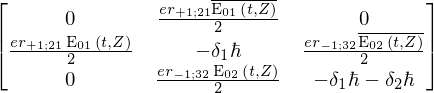

In [57]:
#Htilde = Htilde.subs({E0[0]:Omega1*hbar/r[2][1,0]/e})
#Htilde = Htilde.subs({E0[1]:Omega2*hbar/r[0][2,1]/e})

Htilde

# Optical Bloch Equations

We define the density matrix.

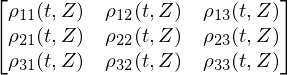

In [58]:
rho = define_density_matrix(Ne, variables=[t, Z])
fprint(rho , print_ascii=print_ascii)

The hamiltonian part of the equations is
\begin{equation}
    \dot{\hat{\rho}}=\frac{i}{\hbar}[\hat{\rho}, \hat{\tilde{H}}]
\end{equation}

In [59]:
hamiltonian_terms=(I/hbar*(rho*Htilde-Htilde*rho)).expand()
# fprint(hamiltonian_terms, print_ascii=print_ascii)

There are two Lindblad operators, since there are two spontaneous decay channels.

In [60]:
lindblad_terms =gamma[1,0]*lindblad_operator(ket(1,Ne)*bra(2,Ne),rho)
lindblad_terms+=gamma[2,1]*lindblad_operator(ket(2,Ne)*bra(3,Ne),rho)

# fprint(lindblad_terms, print_ascii=print_ascii)

The Optical Bloch equations are thus.

In [61]:
eqs = hamiltonian_terms + lindblad_terms

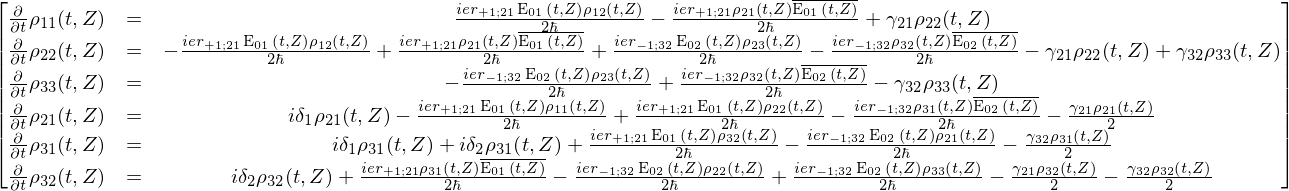

In [62]:
eqsign=symbols("=")
eqs_list=[]
for mu in range(0,Ne**2-1 -(Ne**2 - Ne)/2+1):
    ii,jj,s=IJ(mu,Ne)
    i=ii-1; j=jj-1
    eqs_list+=[[Derivative(rho[i,j],t),eqsign,eqs[i,j]]]
eqs_list=Matrix(eqs_list)
fprint(eqs_list, print_ascii=print_ascii)

# Wave equation

From Maxwell's equations in a dielectric medium it can be shown that in the abscence of bound charges, and magnetization currents, the electric field and the polazation of the medium follow the inhomogeneous wave equation.

\begin{equation}
    \nabla^2 \vec{E} - \frac{1}{c^2} \partial^2_t \vec{E}= \mu_0 \partial_t^2 \vec{P}
\end{equation}

We have also taken our fields to be of the form

\begin{equation}
    \vec{E}(t,\vec{R})=\vec{E}^{+}+\vec{E}^{-}=\frac{1}{2} \sum_l \vec{E}^{l(+)}(t,\vec{R}) e^{i(\vec{k}^l \cdot \vec{R} -\omega^l t)} +c.c.
\end{equation}

The $(+)$ part of the field is explicitly

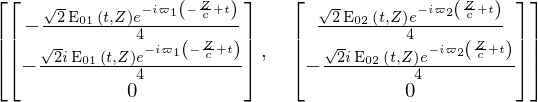

In [63]:
E_cartesian_p

introducing this into the wave equation we get

In [64]:
def laplacian_cylindric(scalar,coords,full=False):
    R,Phi,Z=coords
    return Derivative(scalar,Z,2).doit()

def laplacian_vec_cylindric(vector,coords,full=False):
    return Matrix([ laplacian_cylindric(vi,coords,full=full) for vi in vector])

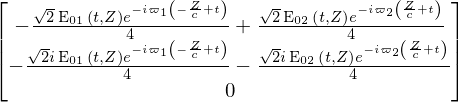

In [65]:
E_cartesian_p_tot = sum([E_cartesian_p[l] for l in range(Nl)], zero_vect)
E_cartesian_p_tot

In [66]:
term1=laplacian_vec_cylindric(E_cartesian_p_tot,[R,Phi,Z]) 
term2=-1/c**2*Matrix([Derivative(vi,t,2).doit() for vi in E_cartesian_p_tot])
lhs=term1+term2
#pprint(lhs,num_columns=150)

And if we consider the amplitudes as slowly varying envelopes (both in time and space) we can approximate them as

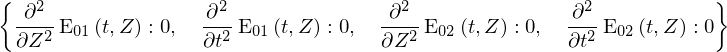

In [67]:
svea_subs={Derivative(E0[0],Z,2):0,Derivative(E0[1],Z,2):0,
           Derivative(E0[0],t,2):0,Derivative(E0[1],t,2):0}
svea_subs

In [68]:
lhs=lhs.subs(svea_subs)
lhs.simplify()
# lhs

On the other hand, we may approximate the macroscopic polarization of the atoms as varying only at the frequencies of the electric field components and at the same polarizations:

\begin{equation}
    \vec{P}=\frac{1}{2}\sum_l \vec{P}^{l(+)} e^{i(\vec{k}^l \cdot \vec{R} -\omega^l t)} +c.c.
\end{equation}


In [69]:
P0 = [Function("P_0^1")(t,R,Z), Function("P_0^2")(t,R,Z)]
# P0

In [70]:
P_cartesian_p=[P0[l]/2            *ep[l]*exp(-I*omega_laser[l]*(t-k[l].dot(RR)/c)) for l in range(Nl)]
P_cartesian_m=[P0[l].conjugate()/2*em[l]*exp(I*omega_laser[l]*(t-k[l].dot(RR)/c)) for l in range(Nl)]

P_cartesian_p_tot=sum(P_cartesian_p, zero_vect)

# P_cartesian_p

The right-hand side of the wave equation

In [71]:
rhs=mu0*Matrix([Derivative(vi,t,2).doit() for vi in P_cartesian_p_tot])
#pprint(rhs)

And in another slowly varying approximation, the terms with $(\omega^1)^2$ are much larger than those with derivatives of the amplitudes.

In [72]:
svea_subs2={Derivative(P0[0],t,1):0, Derivative(P0[1],t,1):0,
            Derivative(P0[0],t,2):0, Derivative(P0[1],t,2):0}
# svea_subs2

In [73]:
rhs=rhs.subs(svea_subs2)
# pprint(rhs)

In [74]:
eqs_wave=lhs-rhs
# pprint(eqs_wave)

These are three scalar equations each of which has coupled terms varying at high frequencies $\omega^l$. However, these frequencies can be decoupled if the polarization of the beams are orthogonal (as they are in our case). Taking a dot product with the polarizations we obtain one equation for each frequency component.

In [75]:
fact1=2*c**2*exp(I*omega_laser[0]*(t-Z/c))/(2*I*omega_laser[0])
lhs1=(fact1*ep[0].conjugate().dot(lhs)).expand()
rhs1=(fact1*ep[0].conjugate().dot(rhs)).expand()

# lhs1, rhs1

In [76]:
fact2=2*c**2*exp(I*omega_laser[1]*(t+Z/c))/(2*I*omega_laser[1])
lhs2=(fact2*ep[1].conjugate().dot(lhs)).expand()
rhs2=(fact2*ep[1].conjugate().dot(rhs)).expand()

# lhs2, rhs2

We take the spacial derivatives to the right-hand side. Just because we can.

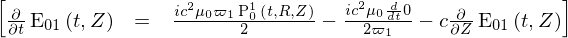

In [77]:
lhs1 = lhs1-c*Derivative(E0[0],Z)
rhs1 = rhs1-c*Derivative(E0[0],Z)
Matrix([lhs1, eqsign, rhs1]).transpose()

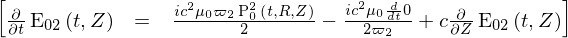

In [78]:
lhs2 = lhs2+c*Derivative(E0[1],Z)
rhs2 = rhs2+c*Derivative(E0[1],Z)
Matrix([lhs2,eqsign,rhs2]).transpose()

We put these equations in terms of Rabi frequencies.

In [79]:
#fact12 = e*r[2][1,0]/hbar
#lhs1 = (fact12*lhs1.subs({E0[0]:Omega1*hbar/r[2][1,0]/e}).doit()).expand()
#rhs1 = (fact12*rhs1.subs({E0[0]:Omega1*hbar/r[2][1,0]/e}).doit()).expand()

#Matrix([lhs1, eqsign, rhs1]).transpose()

In [80]:
#fact2=e*r[0][2,1]/hbar
#lhs2=(fact2*lhs2.subs({E0[1]:Omega2*hbar/r[0][2,1]/e}).doit()).expand()
#rhs2=(fact2*rhs2.subs({E0[1]:Omega2*hbar/r[0][2,1]/e}).doit()).expand()

#Matrix([lhs2,eqsign,rhs2]).transpose()

We may relate the macroscopic polarization to the density matrix if we identify the quantum mechanics operator that corresponds to the polarization. Since the polarization is nothing but the density of dipole moment, we can see that

\begin{equation}
    \vec{P}=-n \mathrm{Tr}(e \vec{\hat{r}} \hat{\rho})
\end{equation}

notice that the minus sign comes from the fact that $\vec{\hat{r}}$ points in the direction of the electron relative to the proton, while the electric dipole moment points in the opposite direction. If we further make the asumption that each frequency component $l$ of the polarization is only driven by the transition $|i\rangle \leftrightarrow |j\rangle$ if $l\in L_{ij}$, then we may decompose $\vec{\hat{r}}$ into $l$ components as.

\begin{equation}
    \vec{\hat{r}} = \sum_l \vec{\hat{r}}^{l(+)} + \vec{\hat{r}}^{l(+)}
\end{equation}

Explicitly:

In [81]:
r_p_component=[ [ Matrix([ [ r_p[p][i,j] if l+1 in Lij[i][j] else 0
                            for j in range(Ne)  ] for i in range(Ne)])
                 for p in range(3)] for l in range(Nl)]

r_m_component=[ [ Matrix([ [ r_m[p][i,j] if l+1 in Lij[i][j] else 0
                            for j in range(Ne)  ] for i in range(Ne)])
                 for p in range(3)] for l in range(Nl)]

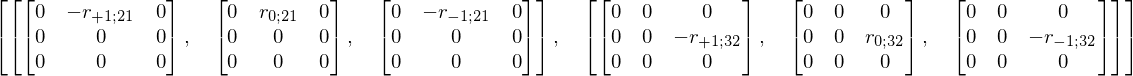

In [92]:
r_p_component

In [82]:
rpl1=r_p_component[0]
rpl2=r_p_component[1]

In [83]:
#n = Function("n", positive=True)(R,Z)
n = symbols("n", positive=True)

In [84]:
vh = Matrix(symbols("r_-,r0,r_+",real=True))
# vh,helicity_to_cartesian(vh)

In [91]:
rpl1_cartesian = [(rpl1[0]-rpl1[2])/sqrt(2),(rpl1[0]+rpl1[2])*I/sqrt(2),rpl1[1]]
# rpl1_cartesian

In [86]:
rpl2_cartesian = [(rpl2[0]-rpl2[2])/sqrt(2),(rpl2[0]+rpl2[2])*I/sqrt(2),rpl2[1]]
# rpl2_cartesian

The following factor of 2 comes from the fact that $P^{l(+)}/2 = -e n Tr(\vec{\hat{r}}^{l(+)}\hat{\rho})$

In [87]:
Ppl1 = -2*n*e*Matrix([ (rpl1_cartesian[i]*rho).trace() for i in range(3)])
Ppl2 = -2*n*e*Matrix([ (rpl2_cartesian[i]*rho).trace() for i in range(3)])

# Ppl1, Ppl2

Taking the dot product with the polarizations we get the polarization amplitudes in terms of density matrix elements.

In [88]:
Ppl1 = ep[0].conjugate().dot(Ppl1).expand()
Ppl2 = ep[1].conjugate().dot(Ppl2).expand()

# Ppl1, Ppl2

In [89]:
rhs1=rhs1.subs({P0[0]:Ppl1})
rhs2=rhs2.subs({P0[1]:Ppl2})

# Maxwell-Bloch equations

And we add these equations to the Bloch equations

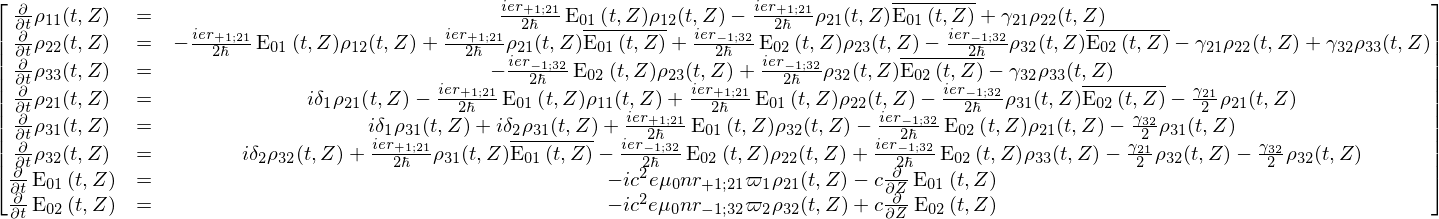

In [90]:
eqsign=symbols("=")
eqs_list=[]
for mu in range(0,Ne**2-1 -(Ne**2 - Ne)/2+1):
    ii,jj,s=IJ(mu,Ne)
    i=ii-1; j=jj-1
    eqs_list+=[[Derivative(rho[i,j],t),eqsign,eqs[i,j]]]

eqs_list += [[lhs1, eqsign, rhs1]]
eqs_list += [[lhs2, eqsign, rhs2]]

eqs_list=Matrix(eqs_list)
fprint(eqs_list, print_ascii=print_ascii)

Question: how to use calculations from detunings as a replacement for calculations for velocity classes.

# Linear approximation

We can linearize this equations by approximating all the population to be in $\rho_{11}$, and taking field $\Omega_1$ to be weak, and the coherences to be small. We will add an $\epsilon$ to all terms involving either coherences or signal field.

In [91]:
epsilon=symbols("varepsilon", real=True)
lin_subs={rho[0,0]:1, rho[1,1]:epsilon**2*rho[1,1], rho[2,2]:epsilon**2*rho[2,2],
          rho[1,0]:epsilon*rho[1,0], rho[0,1]:epsilon*rho[0,1],
          rho[2,0]:epsilon*rho[2,0], rho[0,2]:epsilon*rho[0,2],
          rho[2,1]:epsilon*rho[2,1], rho[1,2]:epsilon*rho[1,2],
          E0[0]: epsilon*E0[0]}
# lin_subs

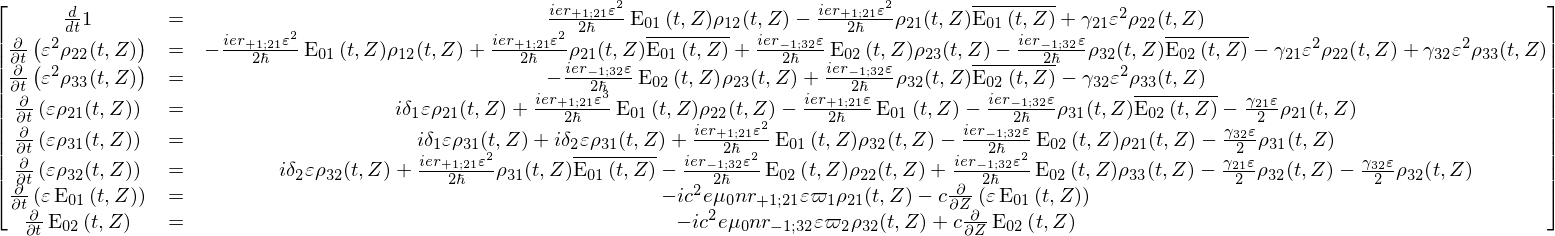

In [92]:
eqs_lin=eqs_list
eqs_lin=eqs_lin.subs(lin_subs)
fprint(eqs_lin, print_ascii=print_ascii)

And so, terms which are doubly small can be neglected.

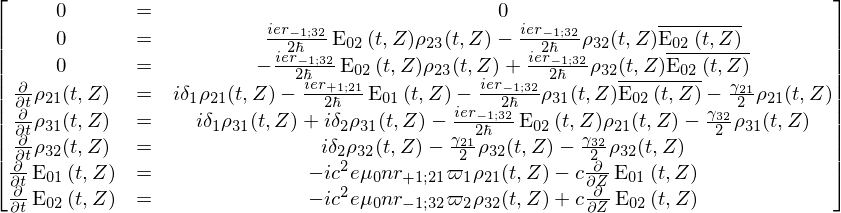

In [93]:
eqs_lin = eqs_lin.subs({epsilon**2:0}).subs({epsilon:1})
eqs_lin = eqs_lin.subs({Derivative(1,t):0,Derivative(0,t):0})
fprint(eqs_lin, print_ascii=print_ascii)

The equations for $\rho_{22}, \rho_{33}$ make a statement about the imaginary part of $\Omega_2\rho_{23}$ being zero. Let's just ignore that. The equation for $\rho_{32}$ is only coupled to itself, and can be easily solved

In [94]:
rho32_sol=exp((-(gamma[1,0]+gamma[2,1])/2+I*delta2)*t)
rho32_sol

In [95]:
Derivative(rho32_sol,t).doit().expand()-eqs_lin[5,2].subs({rho[2,1]:rho32_sol}).expand()

So the dynamics are captured by the equations for $\rho_{21}, \rho_{31}$ and the wave propagation equations.

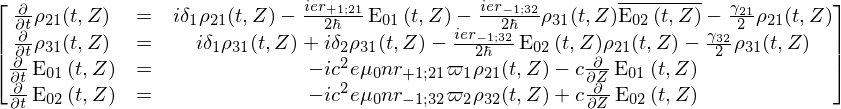

In [96]:
eqss=[[eqs_lin[3:5,:][0,0],eqsign,eqs_lin[3:5,:][0,2]],
      [eqs_lin[3:5,:][1,0],eqsign,eqs_lin[3:5,:][1,2]]]

eqss=eqss+[[eqs_lin[6: ,:][0,0],eqsign,eqs_lin[6: ,:][0,2]],
      [eqs_lin[6: ,:][1,0],eqsign,eqs_lin[6: ,:][1,2]]]

eqss=Matrix(eqss)
eqs_lin=eqss
eqs_lin

If we further consider $\Omega_2$ to be very strong we can neglect the first term on the right-hand side on the last equation.

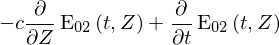

In [97]:
eqOmega2=eqs_lin[3,:][0]-eqs_lin[3,:][2]
eqOmega2=eqOmega2.subs({n:0})
eqOmega2

And thus solve that equation and take $\Omega_2$ as a given quantity. For instance, it might be a gaussian pulse with time duration $\tau_2$:

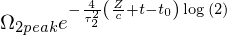

In [98]:
from sympy import log
Omega2_peak, tau2, t0=symbols("Omega2_peak, tau2, t0", positive=True)
Omega2_sol=Omega2_peak*exp(-4*log(2)*(t-t0+Z/c)/tau2**2)
Omega2_sol

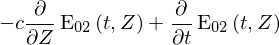

In [99]:
eqOmega2.subs({Omega2:Omega2_sol}).doit()

 Then the equations are reduced to

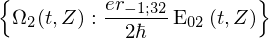

In [100]:
ss_Omega = {E0[1]: 2*Omega2*hbar/r[0][2,1]/e}
ss_Omega_inv = {Omega2: E0[1]/(2*hbar/r[0][2,1]/e)}
ss_Omega_inv

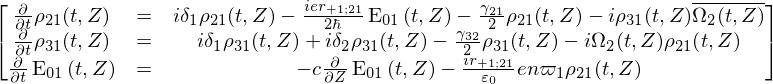

In [101]:
eqs_lin=eqs_lin[:-1,:].subs({c**2: 1/mu0/epsilon0}).subs(ss_Omega)
eqs_lin

# Josh style equations
We find the transformation necessary to get Josh-style equations.

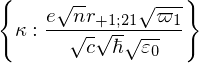

In [102]:
rr = -r_p[0][0, 1]
kappa = symbols("kappa", positive=True)
ss_kappa = {rr: kappa*sqrt(hbar*epsilon0*c/(n*omega_laser[0]*e**2))}
ss_kappa_inv = {kappa: rr*sqrt(n)/sqrt(hbar*epsilon0*c/(omega_laser[0]*e**2))}
ss_kappa_inv

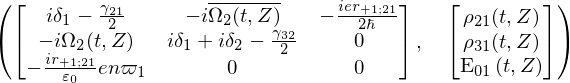

In [103]:
X0 = Matrix([rho[1, 0], rho[2, 0], E0[0]])
M0 = Matrix([[Derivative(eqs_lin[i, 2], X0[j]).doit() for j in range(3)] for i in range(3)])
#M = M.subs(delta2, -delta1)
M0, X0

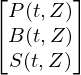

In [104]:
P = Function("P")(t, Z)
B = Function("B")(t, Z)
S = Function("S")(t, Z)
X = Matrix([P, B, S])
X

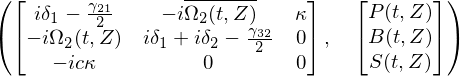

In [105]:
Mtar = Matrix([[I*delta1-gamma[1, 0]/2, -I*Omega2.conjugate(), kappa],
               [-I*Omega2, -gamma[2, 1]/2+I*delta1+I*delta2, 0],
               [-c*kappa*I, 0, 0]])
Mtar, X

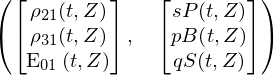

In [106]:
s, p, q = symbols("s, p, q")
trans = [s, p, q]
U = Matrix([[s, 0, 0], [0, p, 0], [0, 0, q]])
ss_U = {X0[i]: X[i]*trans[i] for i in range(3)}
X0, U*X

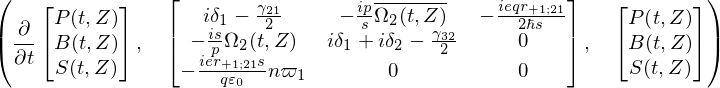

In [107]:
lhs_U = U.inv()*U*X
rhs_U = U.inv()*M0*U*X

M_U = Matrix([[Derivative(rhs_U[i], X[j]).doit() for j in range(3)] for i in range(3)])

Derivative(lhs_U, t), M_U, X

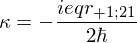

In [108]:
eq1 = Equality(Mtar[0, 2], M_U[0, 2]).subs(s, p).subs(p, 1)
#eq2 = Equality(Mtar[2, 0], M_U[2, 0]).subs(s, p).subs(p, 1)
eq1

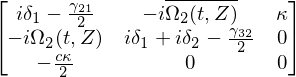

In [109]:
ss_trans = solve(eq1, q, dict=True)[0]
ss_trans.update({s: 1, p: 1})
M_U.subs(ss_trans).subs(ss_kappa)

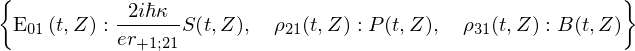

In [110]:
ss_U_final = {i: ss_U[i].subs(ss_trans) for i in ss_U}
S_transform = ss_U_final[E0[0]]/S
ss_U_final

In [111]:
def group(expr, variables, return_coeffs=False):
    coefs = [Derivative(expr, variables[i]).doit() for i in range(len(variables))]
    expr_lin = sum([coefs[i]*variables[i] for i in range(len(variables))])
    remainder = (expr - expr_lin).expand()
    if return_coeffs:
        return coefs
    return expr_lin + remainder

Check the SVEA!

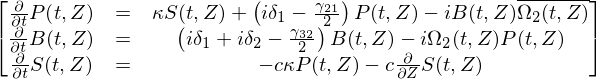

In [112]:
eqs_lin2 = eqs_lin.subs(ss_U_final).doit()
eqs_lin2[0, 2] = group(eqs_lin2[0, 2], X)
eqs_lin2[1, 2] = group(eqs_lin2[1, 2], X)
eqs_lin2[2, 2] = group(eqs_lin2[2, 2], X)

eqs_lin2[2, 0] = eqs_lin2[2, 0]/S_transform
eqs_lin2[2, 2] = (eqs_lin2[2, 2]/S_transform).expand().subs(P, P*2)
eqs_lin2 = eqs_lin2.subs(ss_kappa)

eqs_lin2

We add the Doppler effect. To a linear approximation.

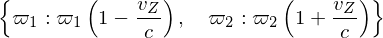

In [113]:
vX, vY, vZ = symbols("v_X, v_Y, v_Z", real=True)
v = Matrix([vX, vY, vZ])
ss_Dop = {omega_laser[l]:
          (1 - cartesian_dot_product(laseres[l].k, v).subs(1.0, 1)/c).subs(vX, 0)*omega_laser[l] for l in range(Nl)}
ss_Dop

Which translates to

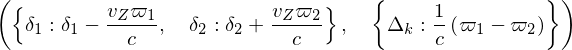

In [114]:
delta = [delta1, delta2]
ss_Dop = {delta[l]:
          (delta[l] - cartesian_dot_product(laseres[l].k, v).subs(1.0, 1)/c*omega_laser[l]).subs(vX, 0) for l in range(Nl)}

Deltak = symbols(r"\Delta_k", real=True)
ss_deltak = {-I*vZ*omega_laser[0]/c + I*vZ*omega_laser[1]/c: -I*Deltak*vZ}
ss_deltak_inv = {Deltak: (omega_laser[0]-omega_laser[1])/c}
ss_deltak, ss_deltak_inv

ss_Dop, ss_deltak_inv

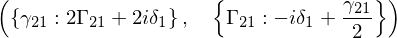

In [115]:
Gamma21 = symbols("Gamma_21")
Gamma32 = symbols("Gamma_32")
#Gamma/2 = gamma[1, 0]/2 - I*(delta1-vZ*omega_laser[0]/c)
ss_Gamma21 = {gamma[1, 0]: 2*(Gamma21+I*delta1)}
ss_Gamma32 = {gamma[2, 1]: 2*(Gamma32+I*delta2)}

ss_Gamma21_inv = {Gamma21: gamma[1, 0]/2- I*(delta1)}
ss_Gamma32_inv = {Gamma32: gamma[2, 1]/2- I*(delta2)}

ss_Gamma21, ss_Gamma21_inv

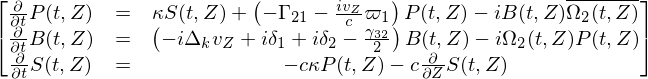

In [116]:
eqs_lin2 = eqs_lin2.subs(ss_Dop)
eqs_lin2[1, 2] = group(eqs_lin2[1, 2].expand(), X).subs(ss_deltak)

eqs_lin2 = eqs_lin2.subs(ss_Gamma21)#.subs(ss_Gamma32)
eqs_lin2[0, 2] = group(eqs_lin2[0, 2].expand(), X)
eqs_lin2[1, 2] = group(eqs_lin2[1, 2].expand(), X)

eqs_lin2

# Pure refraction solution

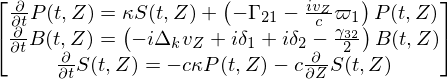

In [117]:
eqs_nc = Matrix([Equality(eqs_lin2[i, 0], eqs_lin2[i, 2]) for i in range(3)])
eqs_nc = eqs_nc.subs(Omega2, 0)
eqs_nc

The second equation is trivial to solve

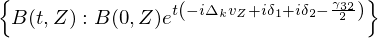

In [118]:
sol_nc21 = {B: exp(t*eqs_nc[1].rhs/B)*B.subs(t, 0)}
sol_nc21

We take the Fourier transform of the remaining equations.

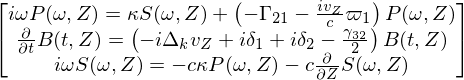

In [119]:
omega = symbols("omega", real=True)
eqs_nc2 = eqs_nc
#eqs_nc2 = eqs_nc.subs(t, omega)
ss_fourier = {diff(P, t): I*omega*P.subs(t, omega),
              diff(S, t): I*omega*S.subs(t, omega),
              P: P.subs(t, omega),
              S: S.subs(t, omega)}

eqs_nc2 = eqs_nc2.subs(ss_fourier)
eqs_nc2

We solve the first equation

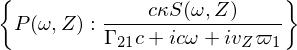

In [120]:
sol_nc22 = solve(eqs_nc2[0], P.subs(t, omega), dict=True)[0]
sol_nc22

Substitute in the third

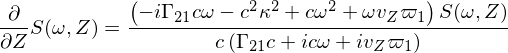

In [121]:
eq3 = Equality(diff(S.subs(t, omega), Z), solve(eqs_nc2[2].subs(sol_nc22), diff(S.subs(t, omega), Z), dict=False)[0])
eq3

Which can be easily solved.

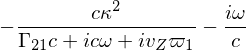

In [122]:
arg = eq3.rhs.factor()/S.subs(t, omega)
#arg = arg.factor()
den = 1/Mul(*arg.args[:-1])
num = arg.args[-1].factor()
num = I*(num/I).expand()

num1 = I*(num.args[1] + I*c**2*kappa**2)
num1 = num1.factor()
num2 = -I*I*c**2*kappa**2

arg_ = num1/den + num2/den
#arg_ = arg_.factor()
arg_

We check that manipulations have not changed anything.

In [123]:
(arg_-arg).factor()

We get the Green's function.

In [124]:
arg = arg_
G_nc = exp(arg*Z)
G_nc

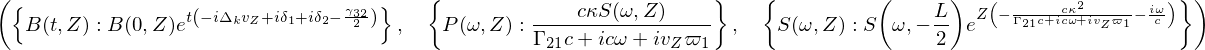

In [125]:
L = symbols("L", positive=True)
sol_nc23 = {S.subs({t: omega}): G_nc*S.subs({t: omega, Z:-L/2})}
sol_nc21, sol_nc22, sol_nc23

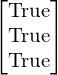

In [126]:
aux = eqs_nc2.subs(sol_nc22)
aux[0] = aux[0].factor()

aux = aux.subs(sol_nc23).doit()
aux[2] = simplify(aux[2].factor())

aux = aux.subs(sol_nc21).doit()
aux

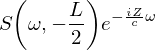

In [127]:
sol_nc23[S.subs(t, omega)].subs(kappa, 0)

# Adiabatic approximation

In [128]:
rho21_ad = solve(eqs_lin2[0, 2], P)[0]

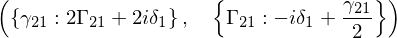

In [129]:
Gamma21 = symbols("Gamma_21")
Gamma32 = symbols("Gamma_32")
#Gamma/2 = gamma[1, 0]/2 - I*(delta1-vZ*omega_laser[0]/c)
ss_Gamma21 = {gamma[1, 0]: 2*(Gamma21+I*delta1)}
ss_Gamma32 = {gamma[2, 1]: 2*(Gamma32+I*delta2)}

ss_Gamma21_inv = {Gamma21: gamma[1, 0]/2- I*(delta1)}
ss_Gamma32_inv = {Gamma32: gamma[2, 1]/2- I*(delta2)}

ss_Gamma21, ss_Gamma21_inv

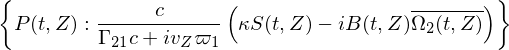

In [130]:
rho21_ad = simplify(rho21_ad.subs(ss_Gamma21))
ss_rho21_ad = {P: rho21_ad}
ss_rho21_ad

So the adiabatic equations are

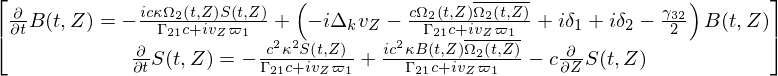

In [131]:
eq1 = eqs_lin2[1, 2].subs(ss_rho21_ad)#.subs(ss_Gamma32).expand()
eq2 = eqs_lin2[2,2].subs(ss_rho21_ad).expand()

X_ad = [B, S]

eq1 = Equality(Derivative(X_ad[0], t), group(eq1, X))
eq2 = Equality(Derivative(X_ad[1], t), group(eq2, X))
eqs_ad = Matrix([eq1, eq2])
eqs_ad

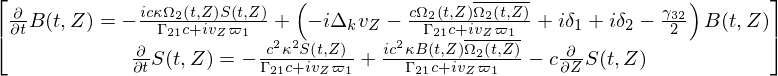

In [132]:
eq1 = eqs_lin2[1, 2].subs(ss_rho21_ad)#.subs(ss_Gamma32).expand()
eq2 = eqs_lin2[2,2].subs(ss_rho21_ad).expand()

X_ad = [B, S]

eq1 = Equality(Derivative(X_ad[0], t), group(eq1, X))
eq2 = Equality(Derivative(X_ad[1], t), group(eq2, X))
eqs_ad = Matrix([eq1, eq2])
eqs_ad

Without any Doppler

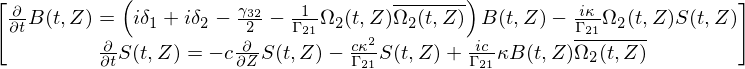

In [133]:
eqs_ad = eqs_ad.subs(vZ, 0)
eqs_ad

We set this in two-photon resonance

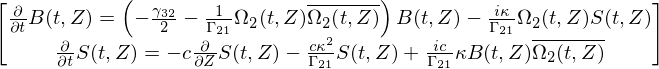

In [134]:
eqs_ad = eqs_ad.subs(delta2, -delta1)
eqs_ad

Similarly, we can get an analytic solution for pure refraction with the adiabatic approximation. Taking the Fourier transform of the second equation in the absence of a control field.

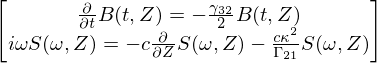

In [135]:
eqs_ad_nc = eqs_ad.subs(Omega2, 0)
eqs_ad_nc[1] = eqs_ad_nc[1].subs(diff(S, t), S*I*omega).subs(t, omega)
eqs_ad_nc

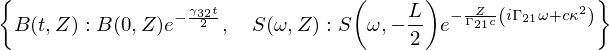

In [136]:
sol_ad_nc = {B: B.subs(t, 0)*exp(-gamma[2, 1]/2*t)}
aux = solve(eqs_ad_nc[1], diff(S.subs(t, omega), Z))[0]/S.subs(t, omega)
sol_ad_nc.update({S.subs(t, omega): exp(aux*Z)*S.subs({t: omega, Z: -L/2})})

sol_ad_nc

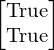

In [137]:
check = eqs_ad_nc.subs(sol_ad_nc).doit()
check[1] = check[1].factor()
check

# Control pulse reference frame
We transform into the "control field reference frame". The lines in space-time where $\Omega_2$ is constant are those of constant $\tau = t + z/c$

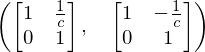

In [138]:
tau, Zp = symbols("tau Z'", real=True)
Lam = Matrix([[1, 1/c], [0, 1]])
q = Matrix([t, Z])
qp = Matrix([tau, Z])
Lam, Lam.inv()

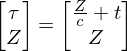

In [139]:
Equality(qp, Lam*q)

Understanding this timespace position as a counter-variant vector, it follows that the partial derivatives are co variant vectors, and transform accordingly. In other words

In [140]:
f = Function("f")
gradp = Matrix([diff(f(tau, Z), tau), diff(f(tau, Z), Z)]).transpose()
grad = Matrix([diff(f(t, Z), t), diff(f(tau, Z), Z)]).transpose()
Equality(gradp, grad*Lam.inv())

or equivalently

In [141]:
Equality(grad, gradp*Lam)

for any function $f$. Using this transformation one can see that equations

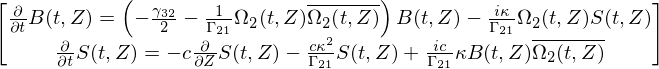

In [142]:
eqs_ad

become

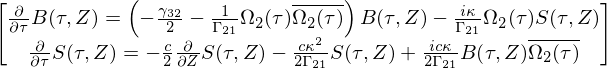

In [143]:
ss_control_frame = {diff(B, t): (gradp*Lam)[0].subs(f(tau, Z), B.subs(t, tau)),
                    diff(S, t): (gradp*Lam)[0].subs(f(tau, Z), S.subs(t, tau)),
                    diff(S, Z): (gradp*Lam)[1].subs(f(tau, Z), S.subs(t, tau))}

eqs_ad_con = eqs_ad.subs(ss_control_frame)
aux = solve(eqs_ad_con[1], diff(S.subs(t, tau), tau))[0].expand()
eqs_ad_con[1] = Equality(diff(S.subs(t, tau), tau), aux)

Omega2_con = Function("Omega_2")(tau)
eqs_ad_con = eqs_ad_con.subs(Omega2, Omega2_con).subs(t, tau)

eqs_ad_con

We can then take a fourier transform of the Z dependence

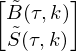

In [144]:
k = symbols("k", real=True)
Bk = Function(r"\tilde{B}")(tau, k)
Sk = Function(r"\tilde{S}")(tau, k)
Xk = Matrix([Bk, Sk])
Xk

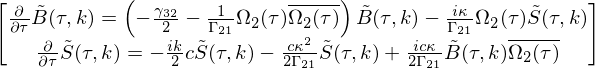

In [145]:
eqs_ad_conk = eqs_ad_con.subs({B.subs(t, tau): Bk, S.subs(t, tau): Sk})
eqs_ad_conk = eqs_ad_conk.subs(Derivative(Sk, Z), I*k*Sk)
eqs_ad_conk

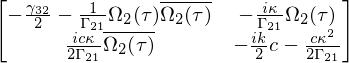

In [146]:
M = Matrix([[Derivative(eqs_ad_conk[i].rhs, Xk[j]).doit() for j in range(2)] for i in range(2)])
M

### Pure refraction solution
Before solving these equations, we need to find $X(\tau=0, k)$ which is the Fourier transform of $X(\tau=0, z)$. In other words, we need a pure refraction solution. We take the Fourier transform in time of our original equations.

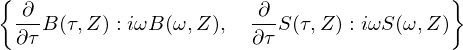

In [147]:
ss_con2 = {diff(B.subs(t, tau), tau): I*omega*B.subs(t, omega),
           diff(S.subs(t, tau), tau): I*omega*S.subs(t, omega)}
ss_con2

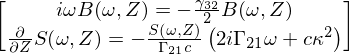

In [148]:
eqs_ad_con2 = eqs_ad_con.subs(Omega2_con, 0).subs(ss_con2).subs(tau, omega)
eqs_ad_con2[1] = Equality(diff(S.subs(t, omega), Z), solve(eqs_ad_con2[1], diff(S.subs(t, omega), Z))[0])
eqs_ad_con2

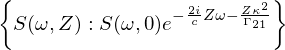

In [149]:
arg = (Z*eqs_ad_con2[1].rhs/S.subs(t, omega)).expand()
rhs = exp(arg)*S.subs({t: omega, Z: 0})
sol_ad_con2 = {S.subs(t, omega) : rhs}
sol_ad_con2

The Fourier transform of this is

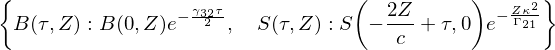

In [150]:
sol_ad_con2 = {S.subs(t, tau): (S.subs({t: tau, Z: 0}).subs(tau, tau + arg.args[1]/I/omega)*exp(arg.args[0])),
               B.subs(t, tau): B.subs(t, 0)*exp(-gamma[2, 1]/2*tau)}
sol_ad_con2

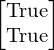

In [151]:
check = eqs_ad_con.subs(Omega2_con, 0).subs(sol_ad_con2).doit()
check[1] = check[1].expand()
check

So the initial condition is $X(\tau = t_{0w}-\tau_2/2, z)$

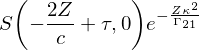

In [152]:
sol_ad_con2[S.subs(t, tau)]

# Solution for square pulses.

Let's assume that the control field is constant for a duration $T$.

In [153]:
T, Omega2a = symbols("T, Omega_2a", positive=True)
phi = symbols("phi", real=True)
T, Omega2a, phi

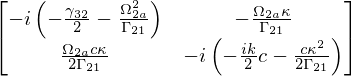

In [154]:
ss_square = {Omega2_con: Omega2a}
M_square = M.subs(ss_square)/I
M_square

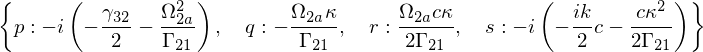

In [155]:
p, q, r, s = symbols("p, q, r, s")
ss_M = {M_square[0, 0]: p, M_square[0, 1]: q, M_square[1, 0]: r, M_square[1, 1]: s}
ss_M_inv = {ss_M[i]: i for i in ss_M}
ss_M_inv

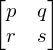

In [156]:
M_simp = M_square.subs(ss_M)
M_simp

We have equations

$$ \dot{X} = i M X $$

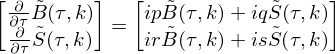

In [157]:
eqs_simp = Equality(diff(Xk, tau), I*M_simp*Xk)
eqs_simp

which we diagonalize

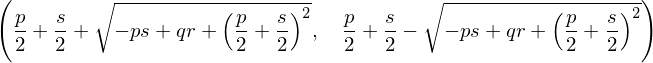

In [158]:
sig = (s+p)/2
delt = (s-p)/2
alp = sig**2 - M_simp.det()
lamp, lamm = sig + sqrt(alp), sig - sqrt(alp)
lamp, lamm

In [159]:
xp, xm = q, q
yp, ym = delt+sqrt(alp), delt-sqrt(alp)

In [160]:
A = Matrix([[xp, xm], [yp, ym]])
Ainv = Matrix([[ym, -xm], [-yp, xp]])/(xp*ym-xm*yp)
D = Matrix([[lamp, 0], [0, lamm]])

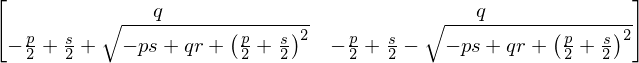

In [161]:
A

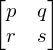

In [162]:
simplify(A*D*Ainv)

We use some dummy variables instead

In [163]:
x_p, x_m, y_p, y_m, lam_p, lam_m = symbols("x_+, x_-, y_+, y_-, \lambda_+, \lambda_-")
x_p, x_m, y_p, y_m, lam_p, lam_m

In [164]:
ss_xy = {xp: x_p, yp: y_p, ym: y_m, lamp: lam_p, lamm: lam_m}
ss_xy_inv = {x_p: xp, x_m: xm, y_p: yp, y_m: ym, lam_p: lamp, lam_m: lamm}
# ss_xy

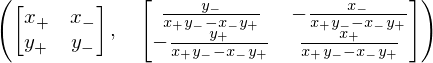

In [165]:
A = Matrix([[x_p, x_m], [y_p, y_m]])
Ainv = Matrix([[y_m, -x_m], [-y_p, x_p]])/(x_p*y_m-x_m*y_p)
D = Matrix([[lam_p, 0], [0, lam_m]])
A, Ainv

The mapping after one pulse is

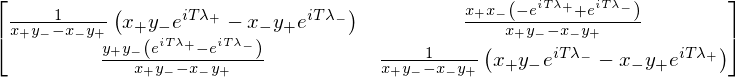

In [166]:
#from sympy import eye
G = sum([A[:, i]*Ainv[i, :]*exp(I*T*D[i, i]) for i in range(2)], zeros(2, 2))
G = simplify(G)
G

We check whether this is a true solution.

In [167]:
S_in = symbols("S_in")
B_in = symbols("B_in")

Xkin = Matrix([B_in, S_in])
Xkout = G*Xkin
Xkout = Xkout.subs(ss_xy_inv).expand().subs(T, tau)
eqs_simp.subs({Xk[0]: Xkout[0], Xk[1]: Xkout[1]}).doit().expand().factor()

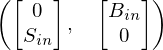

In [168]:
Xin = Xk.subs({Bk: 0, Sk: S_in})
Xint = Xk.subs({Bk: B_in, Sk: 0})
Xin, Xint

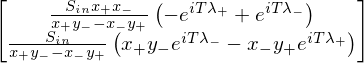

In [169]:
G*Xin

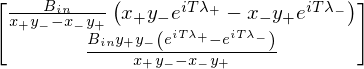

In [170]:
G*Xint

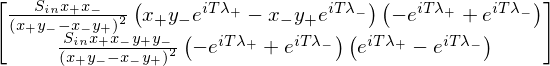

In [171]:
Xint = G*Xin
Xint = Matrix([Xint[0, 0], 0])
Xout = G*Xint
Xout

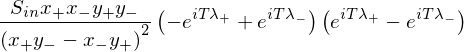

In [172]:
Sout = Xout[1, 0]#.expand()
Sout

{delta: -p/2 + s/2, sigma: p/2 + s/2, alpha: -p*s + q*r + (p/2 + s/2)**2}


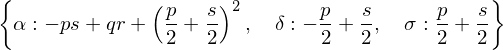

In [173]:
sigma, delta, alpha = symbols("sigma, delta, alpha")
ss_amazing1 = {sigma: (s+p)/2, delta: (s-p)/2, alpha: sig**2 - M_simp.det()}
print ss_amazing1
ss_amazing1

In [174]:
ss_amazing2 = {lam_p: sigma+sqrt(alpha), lam_m: sigma-sqrt(alpha)}
ss_amazing2

In [175]:
ss_amazing3 = {x_p: q, x_m: q}
ss_amazing3

In [176]:
ss_amazing4 = {y_p: delta+sqrt(alpha), y_m: delta-sqrt(alpha)}
ss_amazing4

We substitute the dummy variables.

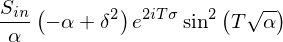

In [177]:
Sout = Xout[1, 0]#.expand()
Sout_ = Sout.subs(ss_amazing2).factor()
Sout_ = Sout_.subs({exp(I*T*sqrt(alpha))-exp(-I*T*sqrt(alpha)): 2*I*sin(T*sqrt(alpha))})
Sout_ = Sout_.subs(ss_amazing3).factor()
Sout_ = Sout_.subs(ss_amazing4)
Sout_ = Sout_.subs({(delta-sqrt(alpha))*(delta+sqrt(alpha)): delta**2-alpha})
Sout_

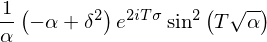

In [178]:
Fk = Sout_/S_in
Fk

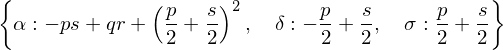

In [179]:
ss_amazing1

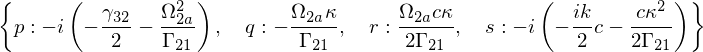

In [180]:
ss_M_inv

We check whether the phase in the exponential factor is real or imaginary.

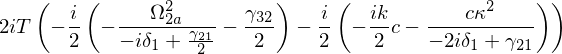

In [181]:
sigma_phase = 2*I*T*ss_amazing1[sigma].subs(ss_M_inv).subs(ss_Gamma21_inv)
sigma_phase

Unsurprisingly, decoherence goes to zero if the the decay frequencies are zero.

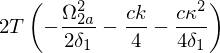

In [182]:
im(sigma_phase).subs({gamma[1, 0]: 0, gamma[2, 1]: 0})

In [183]:
re(sigma_phase).subs({gamma[1, 0]: 0, gamma[2, 1]: 0})

# Recovering previous results
We now seek to put $F(k)$ as

\begin{equation}
    F(k) = \frac{\sin^2(\tilde{C} z(k) )}{z(k)^2}
\end{equation}
where

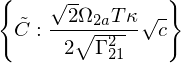

In [184]:
Ctilde = symbols(r"\tilde{C}")
ss_Ctilde = {Ctilde: sqrt(c/2)*Omega2a*T*kappa/sqrt(Gamma21**2)}
ss_Ctilde

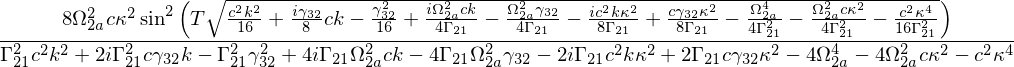

In [185]:
F_aux = Fk.subs(sigma, 0).subs(ss_amazing1).subs(ss_M_inv).factor()
F_aux

In [186]:
from sympy import diff
def coeffs(expr, x, deg=1):
    coefs = []
    rem = expr
    for n in reversed(range(1, deg+1)):
        coef = diff(rem, x, n)/n
        term = coef*x**n
        rem = rem - term
        rem = rem.expand()
        coefs += [coef]
    coefs += [rem]
    return list(reversed(coefs))

We extract the square of the argument of the sine ($\tilde{C}^2 z(k)^2 $)

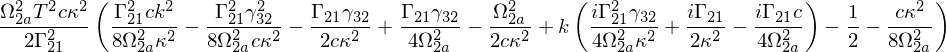

In [187]:
#arg1 = F_aux.args[1].args[0].args[0]**2
arg1 = F_aux.args[5].args[0].args[0]**2
fact1 = T**2*c/Gamma21**2*(kappa*Omega2a)**2*(sqrt(8)/4)**2
#fact1 = T**2/16/Gamma21**2

arg1_ = arg1/fact1
arg1_ = arg1_.factor().expand()
coefs1 = coeffs(arg1_, k, 2)
arg1_= sum([coefs1[i]*k**i for i in reversed(range(3))])
arg1_ = arg1_*fact1
arg1_

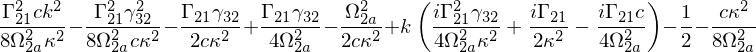

In [188]:
# arg2 = 1/(F_aux.args[0]*F_aux.args[2])
arg2 = 1/Mul(*F_aux.args[:-1])
# fact2 = kappa**2*Omega2a**2/Gamma21**4/64/8* (8*c*kappa*Omega2a)**2
fact2 = 1
# fact2 = c*kappa**2*Omega2a**2/(64*Gamma21**4)

arg2_ = arg2/fact2
arg2_ = arg2_.factor().expand()

coefs2 = coeffs(arg2_, k, 2)
arg2_=sum([coefs2[i]*k**i for i in reversed(range(3))])
arg2_ = arg2_*fact2

arg2_

We check that the manipulations haven't changed anything.

In [189]:
(arg1-arg1_).expand(), (arg2-arg2_).expand()

In [190]:
arg1 = arg1_
arg2 = arg2_

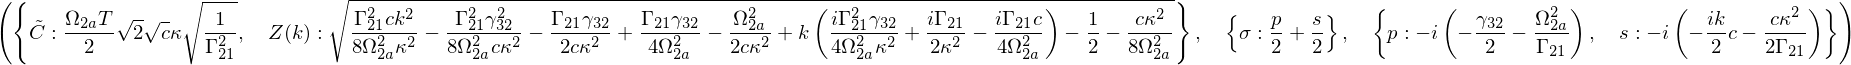

In [191]:
Ctilde = symbols(r"\tilde{C}")
Zk = Function("Z")(k)

ss_guillaume = {sqrt(arg1/fact1): Zk, sqrt(fact1): Ctilde}
ss_guillaume_inv = {Zk: sqrt(arg1/fact1), Ctilde: sqrt(fact1)}
ss_guillaume_inv2 = {ss_amazing1.keys()[1]: ss_amazing1[ss_amazing1.keys()[1]]}
ss_guillaume_inv3 = {ss_M_inv.keys()[1]: ss_M_inv[ss_M_inv.keys()[1]],
                     ss_M_inv.keys()[0]: ss_M_inv[ss_M_inv.keys()[0]]}
ss_guillaume_inv, ss_guillaume_inv2, ss_guillaume_inv3

In [192]:
den = arg2*(Zk/ss_guillaume_inv[Zk])**2
den = den.factor()
#den = den*(Ctilde/ss_guillaume_inv[Ctilde])**2

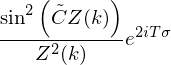

In [193]:
F_guillaume = sin(Ctilde*Zk)**2/den*exp(2*I*T*sigma)
F_guillaume

We generate code to calculate $Z(k)$.

In [194]:
aux = ss_guillaume_inv[Zk]**2
for ii in aux.args:
    ss = str(ii)
    ss = ss.replace("Gamma_21", "Gamma21")
    ss = ss.replace("gamma_32", "gamma32")
    ss = ss.replace("Omega_2a", "Omega")
    ss = ss.replace("I", "1j")
    print "zk += "+ss

zk += -1/2
zk += k*(1j*Gamma21**2*gamma32/(4*Omega**2*kappa**2) + 1j*Gamma21/(2*kappa**2) - 1j*Gamma21*c/(4*Omega**2))
zk += -Omega**2/(2*c*kappa**2)
zk += -c*kappa**2/(8*Omega**2)
zk += Gamma21*gamma32/(4*Omega**2)
zk += -Gamma21*gamma32/(2*c*kappa**2)
zk += -Gamma21**2*gamma32**2/(8*Omega**2*c*kappa**2)
zk += Gamma21**2*c*k**2/(8*Omega**2*kappa**2)


We check that the manipulations haven't changed anything.

In [195]:
arg_gui1 = (Zk*Ctilde).subs(ss_guillaume_inv)
arg_gui1 = arg_gui1**2

F_aux2 = Fk.subs(sigma, 0).subs(ss_amazing1).subs(ss_M_inv).expand()
arg_aux1 = F_aux.args[5].args[0].args[0]#F_aux2.args[4].args[0].args[0]
arg_aux1 = arg_aux1**2

(arg_aux1-arg_gui1).expand().factor()

In [196]:
arg_gui2 = Zk**2
arg_gui2 = arg_gui2.subs(ss_guillaume_inv).expand()

arg_aux2 = 1/Mul(*F_aux.args[:-1])
#arg_aux2 = arg_aux2.subs(ss_amazing1).subs(ss_M_inv)
#arg_aux2 = (1/arg_aux2).expand()

(arg_aux2-arg_gui2).expand()

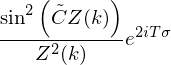

In [197]:
F_guillaume

# Optimal input
We calculate what the optimal input should be.

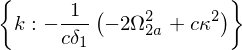

In [283]:
ss_no_dec = {gamma[2, 1]: 0, gamma[1, 0]: 0}
kmin = symbols("k_min", real=True)
kmin_ = solve(ss_guillaume_inv[Zk]**2, k)[0]
kmin_ = re(kmin_.subs(ss_Gamma21_inv)).factor()
kmin_ = kmin_.subs(ss_no_dec).factor()
#kmin = re(kmin.subs(ss_Gamma21_inv).subs(gamma[1, 0], 0)).factor()
ss_kmin = {k: kmin_}
ss_kmin

In [284]:
-(ss_guillaume_inv[Zk]**2).subs(ss_Gamma21_inv).subs(ss_no_dec).subs(k, ss_kmin[k]).factor()

In [285]:
N = symbols("N", integer=True)

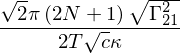

In [286]:
Ctilde_opt = (N +1/Integer(2))*pi
Omega2a_opt = solve(Ctilde_opt- ss_Ctilde[Ctilde], Omega2a)[0]
Omega2a_opt

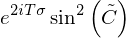

In [287]:
F_guillaume.subs(Zk, 1)#.subs(Ctilde, Ctilde_opt)

We are also interested in finding the two closest zeros of $F(k)$, which appear where the argument of the sine is an integer multiple of $\pi$. For the first Rabi flip unit-efficiency condition, this means

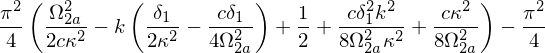

In [288]:
arg = (ss_guillaume_inv[Zk])
arg = -arg.subs(ss_Gamma21_inv).subs(ss_no_dec)**2
arg = (pi/2)**2*arg - (pi/2)**2
arg

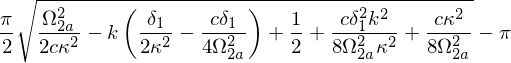

In [292]:
arg = (ss_guillaume_inv[Zk])
arg = -arg.subs(ss_Gamma21_inv).subs(ss_no_dec)**2
arg = pi/2*sqrt(arg) - pi
#arg = (pi/2)**2*arg - (pi/2)**2
arg

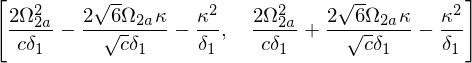

In [293]:
k0 = solve(arg, k)
k0

In [294]:
arg2 = -ss_guillaume_inv[Zk]**2
arg2 = pi/2*sqrt(arg2)
arg2 = arg2.subs(ss_Gamma21_inv).subs(ss_no_dec)
arg2.subs(k, k0[1]).factor()

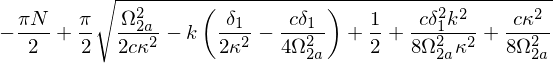

In [295]:
arg = (ss_guillaume_inv[Zk])
arg = -arg.subs(ss_Gamma21_inv).subs(ss_no_dec)**2
arg = pi/2*sqrt(arg) - N*pi/2
#arg = (pi/2)**2*arg - (pi/2)**2
arg

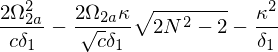

In [296]:
k02 = solve(arg, k)[0]
k02

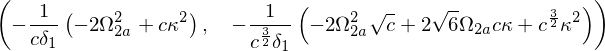

In [297]:
k02.subs(N, 1).factor(), k02.subs(N, 2).expand().factor()

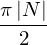

In [298]:
arg2.subs(k, k02).factor()

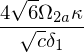

In [299]:
Deltak = solve(arg, k)
Deltak = Deltak[1]-Deltak[0]
Deltak = Deltak.subs(N, 2)
Deltak

However, this seems to be the second zero, and not the first. The number for the width between the first zeroes seems to be

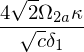

In [300]:
Deltak_ = Deltak/sqrt(3)
Deltak_

this $k$-bandwidth at unit efficiency:

In [301]:
ss_Ctilde_inv = {Omega2a: Ctilde/ss_Ctilde[Ctilde]*Omega2a}
deltak = Deltak_.subs(ss_Ctilde_inv).subs(ss_Gamma21_inv).subs(ss_no_dec)/I
deltak = deltak.subs(Ctilde, pi/2).subs(delta1, 1)
deltak

# Necessary energy
We calculate the Rabi frequency from the pulse energy.

In [214]:
w2, E2 = symbols("w2, E2", positive=True)
r2 = r_m[2][2, 1]

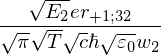

In [215]:
from sympy import gamma as GammaFunction
m = symbols("m", integer=True, positive=True)
sigma1 = symbols("sigma1", positive=True)
Omega2a_en = 4*sqrt(E2)*e*r2/(hbar*w2*sqrt(pi*c*epsilon0*T))*2

sigma1 = T/2
Omega2a_en = sqrt(2)*sqrt(E2)*e*r2/(2*sqrt(pi)*sqrt(c)*sqrt(epsilon0)*hbar*sqrt(sigma1)*w2*sqrt(GammaFunction(1 + 1/(2*m))))
Omega2a_en = Omega2a_en.limit(m, oo)
Omega2a_en

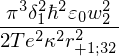

In [216]:
rhs = ss_Ctilde_inv[Omega2a].subs(Ctilde, pi/2).subs(ss_Gamma21_inv).subs(ss_no_dec)/I
eq = Equality(Omega2a_en, rhs)
E_necessary = solve(eq, E2)[0].limit(m, oo)
E_necessary

So we want simultaneously that the necessary energy is low, and that the $k$-bandwidth be high, that is, to maximize

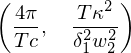

In [217]:
vv = delta1**2*w2**2/T/kappa**2
deltak, 1/vv

In [218]:
ff1, ff2, ff3 = symbols(r"\mathfrak{f}_1, \mathfrak{f}_2, \mathfrak{f}_3")
ff1, ff2, ff3

We can choose arbitrarily $T=\tau_s/\mathfrak{f}$

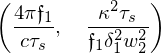

In [219]:
cap, taus = symbols("cap, tau_s", positive=True)

deltak.subs(T, taus/ff1), 1/vv.subs(T, taus/ff1)

And then calculate the signal duration to fit everything else

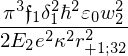

In [220]:
tau_s_optimal = solve(Equality(E_necessary.subs(T, taus/ff1), E2), taus)[0]
tau_s_optimal

We can summarize this with the following equations. The condition for high efficiency (in addition to the necessary detuning):

In [221]:
eq1 = Equality(ff1*T, taus)
eq1

The condition for the necessary energy.

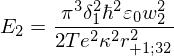

In [222]:
eq2 = Equality(E2, E_necessary)
eq2

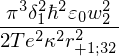

In [223]:
eq2.rhs.limit(m, oo)

The condition for the adiabatic approximation.

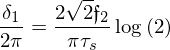

In [224]:
eq3 = Equality(delta1/2/pi, ff2*2*sqrt(2)*log(2)/pi/taus)
eq3

And the second condition for the adiabatic approximation.

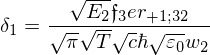

In [225]:
eq4 = Equality(delta1, ff3*Omega2a_en)
eq4

In [226]:
(taus, T, delta1), (ff2, ff1), (E2, w2, kappa)

In [227]:
(taus, T, delta1, E2), (ff2, ff1, ff3), (w2, kappa)

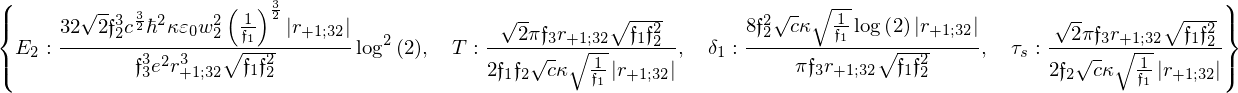

In [228]:
sol = solve([eq1, eq2, eq3, eq4], [taus, T, delta1, E2], dict=True)[0]
sol

np.pi**2*ff1**2*ff3**2/(2*c*kappa**2)


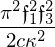

In [229]:
def get_code(expr):
    s = str(expr)
    s = s.replace(r"\mathfrak{f}_", "ff")
    s = s.replace("varepsilon0", "epsilon_0")
    s = s.replace("log", "np.log")
    s = s.replace("pi", "np.pi")
    s = s.replace("r_{+1;32}", "r2")
    s = s.replace("E2", "energy_pulse2")
    s = s.replace("*e*", "*e_charge*")
    return s

print get_code(sol[taus]**2)
sol[taus]**2

np.pi**2*ff3**2/(2*c*kappa**2)


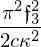

In [230]:
print get_code(sol[T]**2)
sol[T]**2

64*ff2**2*c*kappa**2*np.log(2)**2/(np.pi**2*ff1**2*ff3**2)


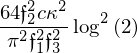

In [231]:
print get_code(sol[delta1]**2)
sol[delta1]**2

2048*ff2**4*c**3*hbar**4*kappa**2*epsilon_0**2*w2**4*np.log(2)**4/(ff1**4*ff3**6*e_charge**4*r2**4)


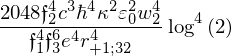

In [232]:
print get_code(sol[E2]**2)
sol[E2]**2

In [233]:
ff = 1-exp(-sqrt(t))
ff

In [234]:
diff(ff, t).subs(t, 0)

In [235]:
ff.limit(t, oo)

# Decoherence
Solving the second equation in the abscence of a control field we obtain a spin wave proportional to

In [236]:
Delta, sigma = symbols("Delta sigma", positive=True)
f = exp(I*Delta*t*vZ)
f

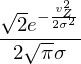

In [237]:
g=1/sqrt(2*pi)/sigma*exp(-(vZ/sigma)**2/2)
g

In [238]:
Doppler_decoherence=integrate(g*f, (vZ, -oo, oo)).factor()
Doppler_decoherence

In [239]:
decoherence = Doppler_decoherence*exp(-gamma[2, 1]*t/2)
decoherence

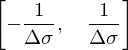

In [240]:
solve(log(Doppler_decoherence**2)+1, t)

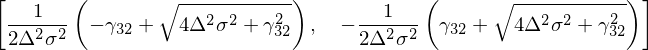

In [241]:
solve(log(decoherence**2)+1, t)

In [242]:
A, B, C = symbols("A, B, C")
omega87, omega97 = symbols("omega87, omega97", positive=True)

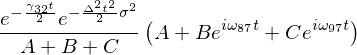

In [243]:
decoherence_hfs = decoherence*(A+B*exp(I*omega87*t)+C*exp(I*omega97*t))/(A+B+C)
decoherence_hfs

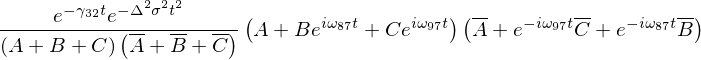

In [244]:
eta_hfs = decoherence_hfs*decoherence_hfs.conjugate()
eta_hfs

In [245]:
D = symbols("D", positive=True)

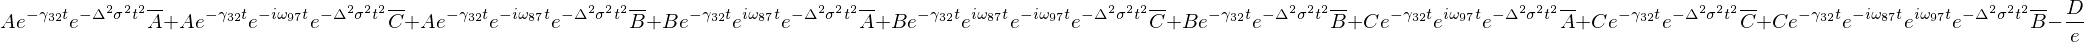

In [246]:
eq = eta_hfs
eq = eq.subs({(A+B+C)*(A+B+C).conjugate(): 1}) -exp(-1)*D
eq = eq.expand()
eq

[1]  H.J. Metcalf and P. van der Straten. Laser Cooling and Trapping. Graduate Texts in Contempo-
rary Physics. Springer New York, 2001.

[2] Daniel Adam Steck. Quantum and Atom Optics. Oregon Center for Optics and Department of Physics, University of Oregon Copyright © 200

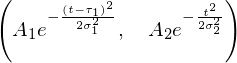

In [247]:
from sympy import integrate
sig = symbols("sigma1:3", positive=True)
tau = symbols("tau1:3", positive=True)
A = symbols("A1:3", positive=True)
t, tp = symbols("t, t'", real=True)

g1 = A[0]*exp(-((t-tau[0])/sig[0])**2/2)
g2 = A[1]*exp(-((t-tau[1])/sig[1])**2/2).subs(tau[1], 0)
g1, g2

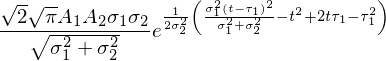

In [248]:
con = integrate(g1.subs(t, tp)*g2.subs(t, t-tp), (tp, -oo, oo))
con = simplify(con)
con

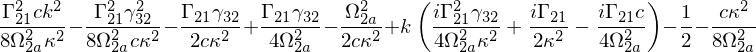

In [249]:
aa = con.args[-1].args[0]
aaa = aa.factor()
aux.subs(aa, aaa)

In [250]:
ss = {sig[0]: 1.0, sig[1]: 0.5, A[0]: 1.0, A[1]: 2.0, tau[0]: 1.0}
ss

In [251]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
ts = np.linspace(-10, 10, 1000)
dt = ts[1]-ts[0]
g1s = g1.subs(ss)
g1s = [g1s.subs(t, ti) for ti in ts]
g2s = g2.subs(ss)
g2s = [g2s.subs(t, ti) for ti in ts]

g1g2s = con.subs(ss)
g1g2s = [g1g2s.subs(t, ti) for ti in ts]

g1g2ss = np.convolve(g1s, g2s, mode="same")*dt

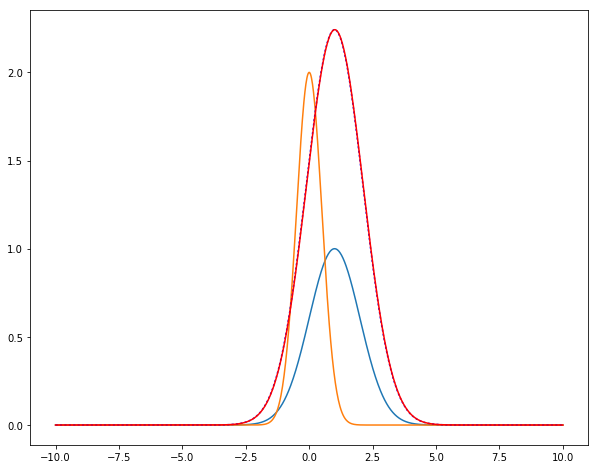

In [252]:
plt.figure(figsize=(10, 8))
plt.plot(ts, g1s)
plt.plot(ts, g2s)
plt.plot(ts, g1g2s, "b:")
plt.plot(ts, g1g2ss, "r-")